In [1]:
import numpy as np
import scipy
import os
from tqdm import tqdm
import pywt
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
def compress(original, level, threshold_percentage, wavelet):
    wavelet_repr = pywt.wavedec2(
        original, wavelet, level=level, mode='periodization')
    c_vals, c_idx = pywt.coeffs_to_array(wavelet_repr)
    absolute_coefficients = np.abs(c_vals).flatten()
    threshold = np.max(absolute_coefficients) * threshold_percentage/100
    c_t = pywt.threshold(c_vals, value=threshold, mode='hard')
    threshold_coefficients = pywt.array_to_coeffs(
        c_t, c_idx, output_format='wavedec2')
    return threshold_coefficients


def extract_coefficients(raw_data, level, threshold, wavelet, num):
    coefficients_arr = []
    for i in range(raw_data.shape[2]):
        subject_data = raw_data[:, :, i]
        transformed = compress(subject_data, level, threshold, wavelet)
        if num == 0:
            transformed_array = transformed[0]
        elif num == -1:
            transformed_array = pywt.coeffs_to_array(
                transformed)[0]  # all coefficients
        else:
            transformed_array = np.vstack(
                (transformed[num][0], transformed[num][1], transformed[num][2]))

        coefficients_arr.append(transformed_array.flatten())

    coefficients_arr = np.array(coefficients_arr)
    return coefficients_arr


def extract_pca_features(coefficients, num_components):
    pca = PCA(n_components=num_components)
    pca.fit(coefficients)
    pca_coefficients = pca.transform(coefficients)
    return pca_coefficients


def calculate_entropy(array):
    # Get unique values and their frequencies
    _, counts = np.unique(array, return_counts=True)
    # Calculate probabilities
    probabilities = counts / array.size
    entropy = scipy.stats.entropy(probabilities)
    return entropy


def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) >
                                               np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]


def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]


def extract_stat_features(coefficients):
    all_features = []
    for i in range(coefficients.shape[0]):
        subject_coefficients = coefficients[i, :]
        entropy = calculate_entropy(subject_coefficients)
        statistics = calculate_statistics(subject_coefficients)
        crossings = calculate_crossings(subject_coefficients)
        features = np.concatenate((statistics, [entropy], crossings))
        all_features.append(features)

    all_features = np.array(all_features)
    return all_features


def calculate_features2(coeff):
    rms = np.sqrt(np.mean(coeff**2))
    mav = np.mean(np.abs(coeff))
    integrated_eeg = np.sum(np.abs(coeff))
    simple_square_integral = np.sum(np.abs(coeff)**2)
    var = np.var(coeff)
    aac = np.mean(np.abs(np.diff(coeff)))
    wl = np.sum(np.abs(np.diff(coeff)))  # wave length
    zc = np.sum(np.abs(np.diff(np.sign(coeff))))  # zero crossing
    ssc = np.sum(np.abs(coeff[1:] * coeff[:-1]))  # slope sign change
    return [rms, mav, integrated_eeg, simple_square_integral, var, aac, wl, zc, ssc]


def pick_coefficients(raw_data, level, threshold, wavelet):
    coefficients_arr = []
    for i in range(raw_data.shape[2]):
        subject_data = raw_data[:, :, i]
        transformed = compress(subject_data, level, threshold, wavelet)
        t = [calculate_features2(transformed[k][j]) for j in range(3)
             for k in range(1, len(transformed))]
        # t = [transformed[j].flatten() for j in range(1, len(transformed)-1)]
        coefficients_arr.append(np.array(t).flatten())
    return np.array(coefficients_arr)


In [3]:
input_folder = os.path.join("intermediate", "mi", "transformed")
labels_folder = os.path.join("data", "mi", "labels")
all_labels = []

for l in os.listdir(labels_folder):
    y_train = scipy.io.loadmat(os.path.join(labels_folder, l))["y_train"]
    y_test = scipy.io.loadmat(os.path.join(labels_folder, l))["y_test"]
    all_labels = np.concatenate((y_train, y_test), axis=1).reshape(-1)

In [4]:
pareto_curve = np.load("mi_5000.npy", allow_pickle=True)
wavelet_configs = [(c[2], c[3], c[4])
                   for c in pareto_curve]  # wavelet, level, threshold
print(len(wavelet_configs))
# filter out wavelet configs that are below level = 3
# wavelet_configs = [c for c in wavelet_configs if c[1] >= 3]
# len(wavelet_configs)

5000


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
# model = MLPClassifier(random_state=0, max_iter=1000)

wavelet_accuracies = []
f = "sp1s_aa_100hz.npy"
data = np.load(os.path.join(input_folder, f))
for wavelet_config in tqdm(wavelet_configs):
    try:
        # coefficients = extract_coefficients(data, wavelet_config[1],
        # wavelet_config[2], wavelet_config[0], -1)

        features = pick_coefficients(data, wavelet_config[1],
                                     wavelet_config[2], wavelet_config[0])
        # features = extract_pca_features(coefficients, 400)
        # # features = extract_stat_features(coefficients)
        features = np.column_stack((features, all_labels))
        X_train, X_test, Y_train, Y_test = train_test_split(
            features[:, :-1], features[:, -1], train_size=0.8, test_size=0.2, random_state=0)
        # # kfold = model_selection.KFold(
        # # n_splits=10, random_state=0, shuffle=True)
        # # cv_results = model_selection.cross_validate(
        # #     model, X_train, Y_train, cv=kfold, scoring=scoring)

        clf = model.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        score = accuracy_score(Y_test, y_pred)
        wavelet_accuracies.append(score)
    except Exception as e:
        wavelet_accuracies.append(0)
        print(e)


In [ ]:
w_np = np.array(wavelet_accuracies)
np.save("mi_5000_lda.npy",w_np)

In [10]:
accs = np.load("mi_5000_lda.npy")
res = np.column_stack((pareto_curve, accs))
np.save("mi_5000_lda.npy", res)

In [ ]:
wavelet_config = wavelet_configs[3099]
print(wavelet_config)
features = pick_coefficients(data, wavelet_config[1],
                                 wavelet_config[2], wavelet_config[0])
features = np.column_stack((features, all_labels))
# X_train, X_test, Y_train, Y_test = train_test_split(
#         features[:, :-1], features[:, -1], train_size=0.8, test_size=0.2, random_state=0)
# check if numpy array is all zeros

Text(0.5, 1.0, 'Error rate vs CR (PCA,Stat,RMS)')

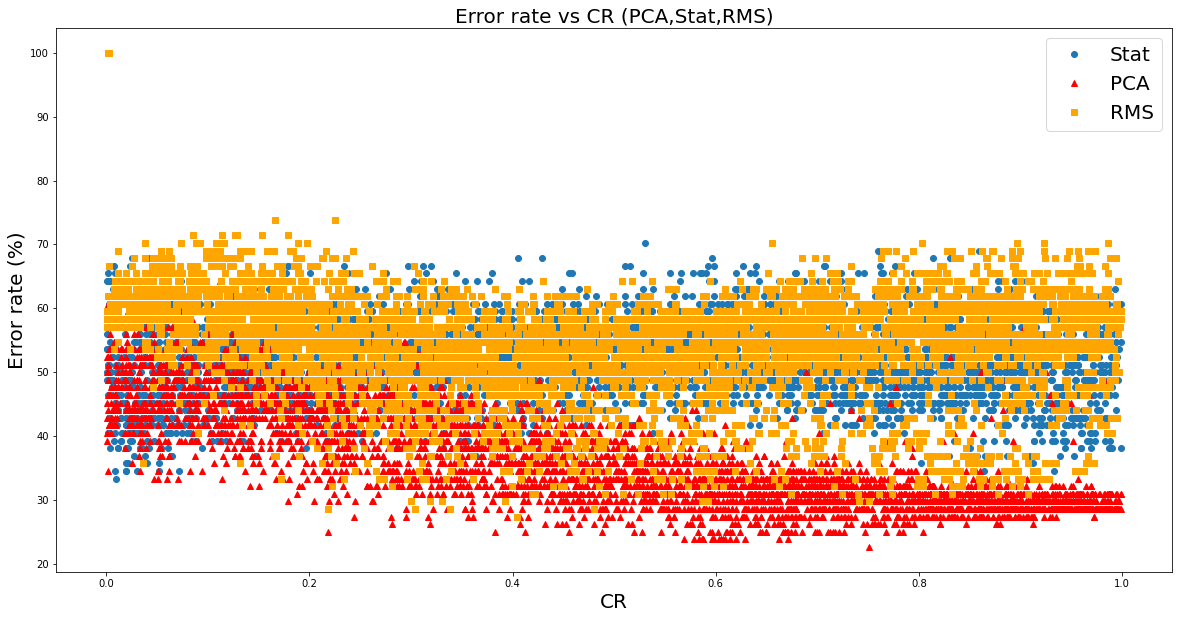

In [23]:
wa = np.load("wavelet_accuracies-stats_5000.npy", allow_pickle=True)
wa2 = np.load("wavelet_accuracies-pca_5000.npy", allow_pickle=True)
wa3 = np.load("mi_5000_lda.npy", allow_pickle=True)
errs_wa = (1 - wa[:, -1].astype(float))*100
errs_wa2 = (1 - wa2[:, -1].astype(float))*100
errs_wa3 = (1 - wa3[:, -1].astype(float))*100

plt.figure(figsize=(20, 10))
plt.plot(pareto_curve[:, 0], errs_wa, "o")
plt.plot(pareto_curve[:, 0], errs_wa2, "^", color="red")
plt.plot(pareto_curve[:, 0], errs_wa3, "s", color="orange")
plt.ylabel("Error rate (%)", fontsize=20)
plt.xlabel("CR", fontsize=20)
plt.legend(["Stat", "PCA", "RMS"], fontsize=20)
plt.title("Error rate vs CR (PCA,Stat,RMS)", fontsize=20)

In [24]:
def pareto_line(sim, x_idx=0, y_idx=1):
    # sort sim by cr
    sim = sim[sim[:, x_idx].argsort()]
    lows = []
    opt = 0
    for i in range(len(sim)):
        if sim[i][x_idx] >= sim[opt][x_idx] and sim[i][y_idx] <= sim[opt][y_idx]:
            lows.append(sim[i])
            opt = i
    return np.array(lows, dtype=object)


In [61]:
import pandas as pd
comb_stats = np.column_stack((pareto_curve, 1-wa[:, -1].astype(float)))
comb_pca = np.column_stack((pareto_curve, 1-wa2[:, -1].astype(float)))
np.save("wa_pca_comb.npy", comb_pca)
p_stats = pareto_line(comb_stats, 0, 6)
p_pca = pareto_line(comb_pca, 0, 6)
df_stats = pd.DataFrame(p_stats, columns=["CR", "PRD",
                                          "wavelet", "level", "Threshold", "epoch", "error"])
df_stats = df_stats.sort_values(by=["error"])
df_stats


,CR,PRD,wavelet,level,Threshold,epoch,error
8,0.009286,95.79135,rbio1.1,1,76.776792,402,0.333333
7,0.009104,87.36041,sym2,2,84.245725,158,0.345238
6,0.003571,98.562987,rbio2.6,1,96.057024,82,0.380952
4,0.002143,98.576619,db5,1,96.383386,317,0.404762
5,0.003571,97.496961,bior1.1,1,86.996695,151,0.404762
3,0.002143,98.596922,sym3,1,93.928516,401,0.464286
2,0.000714,99.435931,haar,1,89.858083,296,0.488095
1,0.000714,99.302566,db3,1,95.393749,70,0.5
0,0.000663,99.545996,bior1.1,3,90.013197,147,0.642857


In [49]:
df = pd.DataFrame(p_pca, columns=["CR", "PRD",
                               "wavelet", "level", "Threshold", "epoch", "error"])
# multiply error by 100 and limit to 2 decimal places
df["error"] = df["error"].apply(lambda x: round(x*100, 2))
# sort by error (ascending)
df = df.sort_values(by=["error"])
df.head(20)

,CR,PRD,wavelet,level,Threshold,epoch,error
42,0.750714,8.491578,db7,1,7.52468,202,22.62
23,0.568571,17.774011,bior1.5,1,9.932812,387,23.81
24,0.578571,17.358101,bior1.5,1,15.001225,6,23.81
25,0.583571,13.312185,db7,1,8.250744,92,23.81
26,0.586429,15.173461,bior1.5,1,11.934785,267,23.81
27,0.587143,8.865487,bior1.3,1,6.913877,186,23.81
28,0.587857,9.643187,bior1.5,1,6.919791,352,23.81
29,0.596429,15.069314,bior1.5,1,9.347913,324,23.81
30,0.597143,11.256428,bior1.5,1,8.01219,227,23.81
31,0.598571,12.831586,bior1.5,1,8.595681,171,23.81


In [59]:
compression_ps = np.load("mi_5000_pareto.npy", allow_pickle=True)
# compression_ps[0]
df_compress = pd.DataFrame(compression_ps, columns=["CR", "PRD",
                                                    "wavelet", "level", "Threshold", "epoch"])
df_compress = df_compress.sort_values(by=["PRD"])
df_compress.head(20)

,CR,PRD,wavelet,level,Threshold,epoch
62,0.928382,0.0,rbio1.1,3,0.009184,35
61,0.923077,0.006433,bior1.1,3,0.023652,10
60,0.917772,0.034837,db1,3,0.070969,94
59,0.912467,0.05155,haar,3,0.091068,165
58,0.907825,0.079926,haar,3,0.107729,257
57,0.897878,0.130903,db1,3,0.15114,351
56,0.897878,0.210633,db1,3,0.233941,245
55,0.883289,0.254378,haar,3,0.272025,2
54,0.855438,0.318875,rbio1.1,3,0.259646,400
53,0.850796,0.599898,bior1.1,3,0.447882,302


In [ ]:
df# multi thread version of the above
from concurrent.futures import ThreadPoolExecutor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
f = "sp1s_aa_100hz.npy"
data = np.load(os.path.join(input_folder, f))
wavelet_accuracies = []


def compute_accuracy(data, wavelet_config):
    # coefficients = extract_coefficients(data, wavelet_config[1],
    # wavelet_config[2], wavelet_config[0], -1)

    # features = extract_stat_features(coefficients)
    model = LinearDiscriminantAnalysis()
    features = pick_coefficients(data, wavelet_config[1],
                                 wavelet_config[2], wavelet_config[0])
    features = np.column_stack((features, all_labels))
    X_train, X_test, Y_train, Y_test = train_test_split(
        features[:, :-1], features[:, -1], train_size=0.8, test_size=0.2, random_state=0)
    if np.all((X_train == 0)):
        return 0
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(Y_test, y_pred)
    return score


# create a thread pool
thread_pool = ThreadPoolExecutor(max_workers=None)

# submit tasks to the thread pool
tasks = [thread_pool.submit(compute_accuracy, data, config, model)
         for config in wavelet_configs]

# collect results from completed tasks
for task in tqdm(tasks, total=len(tasks)):
    wavelet_accuracies.append(task.result())


In [ ]:
wcs = np.array(wavelet_configs[:62])
np.where(wcs[:, 1].astype(int) == 1)[0]
wcs

In [ ]:
wavelet_accuracies = np.array(wavelet_accuracies)*100
np.save("wavelet_accuracies_5000.npy", wavelet_accuracies)

In [ ]:
# Plot CR vs accuracy
plt.figure(figsize=(20, 10))
plt.plot(pareto_curve[:, 0], wavelet_accuracies,
            label="Accuracy", marker='^')
plt.xlabel("CR")
plt.ylabel("Accuracy")
plt.title("Accuracy vs CR")

In [ ]:
# Plot PRD vs accuracy
plt.figure(figsize=(20, 10))
plt.plot(pareto_curve[:, 1], wavelet_accuracies, label="Accuracy", marker='^')
plt.xlabel("PRD")
plt.ylabel("Accuracy")
plt.title("Accuracy vs PRD")

In [ ]:
# plot CR vs PRD as dots connected by lines
plt.figure(figsize=(20, 10))
plt.plot(pareto_curve[:, 0], pareto_curve[:, 1],
         label="PRD", marker='^')
plt.plot(pareto_curve[:, 0], wavelet_accuracies, label="Accuracy", marker='*')
plt.xlabel("CR")
plt.ylabel("PRD")
plt.title("PRD vs CR")
plt.legend()


In [ ]:
d = np.load("mi_5000.npy", allow_pickle=True)
a = np.load("wavelet_accuracies-stats_5000.npy")
c = np.column_stack((d, a[:, 3]))
np.save("mi_5000_accs-stats.npy", c)